In [26]:
#This is where the code can be downloaded from: https://github.com/fastai/imagenette

In [1]:
%pip install datasets torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
#from datasets import load_dataset
from tqdm import tqdm
import torchvision.models as models
# from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
# from fastai.vision.all import *
import matplotlib.pyplot as plt
#from fastai.vision.augment import Resize
from torch.utils.data import DataLoader
import numpy as np

import os

In [3]:
path = os.path.dirname(os.getcwd())
path += '\imagenette2-160\imagenette2-160'

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\coola\AppData\Local\Temp\ipykernel_19764\2419010984.py:2: SyntaxWarning: invalid escape sequence '\i'
  path += '\imagenette2-160\imagenette2-160'


In [4]:
# Define ImageNet normalization statistics
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats)
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=os.path.join(path, 'train'), transform=common_transforms)
val_dataset = ImageFolder(root=os.path.join(path, 'val'), transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
for images, labels in train_loader:
    shape  = images.size()
    print(images.size())  # This will give you the size of the images batch
    break  # Exit after the first batch

torch.Size([64, 3, 224, 224])


In [6]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [8]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [9]:
# NEW MODEL - UNFREEZING THE FIRST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model2 = model

# Freeze all parameters first
for param in model2.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer
new_layer = nn.Sequential(
     nn.ReLU(),
     nn.Linear(56, 56),
     nn.ReLU()
)
model2.layer1[0].conv1 = new_layer

model2.fc = nn.Linear(model.fc.in_features, num_classes)

# for param in model.layer4[1].conv2.parameters():
#     param.requires_grad = True

for param in model2.fc.parameters():
  param.requires_grad = True

for param in model2.layer4[1].conv2.parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
model2.to(device)

summary(model2, (3, 224, 224))
model2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
              ReLU-5           [-1, 64, 56, 56]               0
            Linear-6           [-1, 64, 56, 56]           3,192
              ReLU-7           [-1, 64, 56, 56]               0
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): ReLU()
        (1): Linear(in_features=56, out_features=56, bias=True)
        (2): ReLU()
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [11]:
num_epochs = 10
train_loss_changed = np.zeros(num_epochs)
val_accuracy_changed = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_changed[epoch] = train(model2, train_loader, criterion, optimizer, device)
    val_accuracy_changed[epoch] = evaluate(model2, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_changed[epoch]:.4f}, Val Accuracy: {val_accuracy_changed[epoch]:.4f}")

100%|██████████| 62/62 [01:47<00:00,  1.73s/it]


Epoch 1, Train Loss: 0.5734, Val Accuracy: 0.8932


100%|██████████| 62/62 [02:20<00:00,  2.27s/it]


Epoch 2, Train Loss: 0.2499, Val Accuracy: 0.9034


100%|██████████| 62/62 [01:58<00:00,  1.91s/it]


Epoch 3, Train Loss: 0.1638, Val Accuracy: 0.9019


100%|██████████| 62/62 [02:29<00:00,  2.41s/it]


Epoch 4, Train Loss: 0.1165, Val Accuracy: 0.8948


100%|██████████| 62/62 [02:00<00:00,  1.94s/it]


Epoch 5, Train Loss: 0.0827, Val Accuracy: 0.9034


100%|██████████| 62/62 [02:00<00:00,  1.95s/it]


Epoch 6, Train Loss: 0.0611, Val Accuracy: 0.9057


100%|██████████| 62/62 [01:58<00:00,  1.91s/it]


Epoch 7, Train Loss: 0.0475, Val Accuracy: 0.9075


100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Epoch 8, Train Loss: 0.0403, Val Accuracy: 0.9011


100%|██████████| 62/62 [01:55<00:00,  1.87s/it]


Epoch 9, Train Loss: 0.0363, Val Accuracy: 0.9057


100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

Epoch 10, Train Loss: 0.0258, Val Accuracy: 0.9065


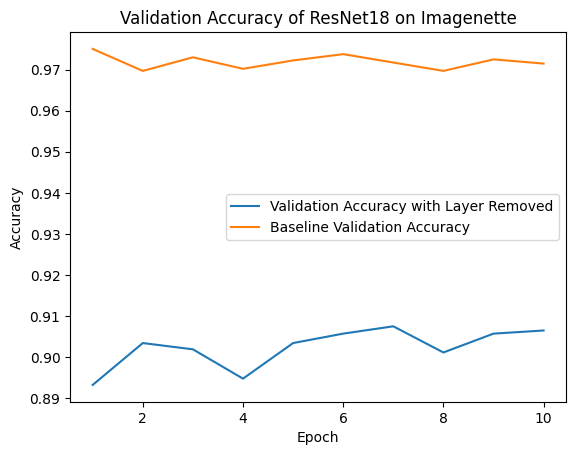

[0.89324841 0.90343949 0.90191083 0.89477707 0.90343949 0.90573248
 0.90751592 0.9011465  0.90573248 0.90649682]
[0.97503185, 0.96968153, 0.97299363, 0.97019108, 0.9722293, 0.97375796, 0.97171975, 0.96968153, 0.97248408, 0.97146497]


In [12]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
val_accuracies = [0.97503185, 0.96968153, 0.97299363, 0.97019108, 0.9722293,  0.97375796, 0.97171975, 0.96968153, 0.97248408, 0.97146497]

epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_changed, label="Validation Accuracy with Layer Removed")
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of ResNet18 on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
print(val_accuracy_changed)
print(val_accuracies)

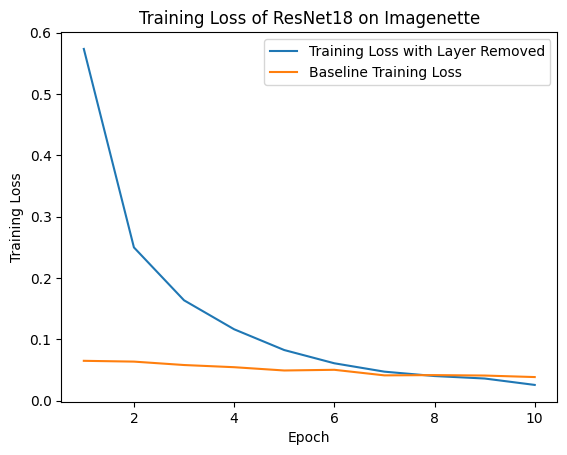

[0.57344329 0.24994023 0.16377732 0.116545   0.08269722 0.06111665
 0.04746172 0.04031771 0.03629793 0.02584921]
[0.06513736, 0.06383715, 0.058279, 0.05473105, 0.04937279, 0.05049743, 0.04141252, 0.04183874, 0.04113671, 0.03865826]


In [13]:
train_losses = [0.06513736, 0.06383715, 0.058279, 0.05473105, 0.04937279, 0.05049743, 0.04141252, 0.04183874, 0.04113671, 0.03865826]

plt.plot(epoch, train_loss_changed, label="Training Loss with Layer Removed")
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.title("Training Loss of ResNet18 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

print(train_loss_changed)
print(train_losses)